In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
from catboost import CatBoostRegressor
import os

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
!ls data_inner/nhanes_1994-2018/

chemicals_clean.csv
chemicals_unclean.csv
comments_clean.csv
comments_unclean.csv
demographics_clean.csv
demographics_unclean.csv
dictionary_drug_codes.csv
dictionary_harmonized_categories.csv
dictionary_nhanes.csv
dietary_clean.csv
dietary_unclean.csv
example_0 - merge_datasets_together.Rmd
example_1 - account_for_nhanes_design.Rmd
example_2 - calculate_summary_statistics.Rmd
example_3 - run_multiple_regressions.Rmd
m - nhanes_1988_2018.R
medications_clean.csv
medications_unclean.csv
mortality_clean.csv
mortality_unclean.csv
nhanes_inconsistencies_documentation.xlsx
occupation_clean.csv
occupations_unclean.csv
questionnaire_clean.csv
questionnaire_unclean.csv
response_clean.csv
response_unclean.csv
w - nhanes_1988_2018.RData
weights_clean.csv
weights_unclean.csv


In [5]:
demographic_path = 'data_inner/nhanes_1994-2018/demographics_clean.csv'
chemical_path = 'data_inner/nhanes_1994-2018/chemicals_clean.csv'
response_path = 'data_inner/nhanes_1994-2018/response_clean.csv'
dictionary_path = 'data_inner/nhanes_1994-2018/dictionary_nhanes.csv'
translations_path = 'data/columns_translations.csv'

# Load dataframes with specified columns
demographics = pd.read_csv(demographic_path, index_col=0, usecols=['RIDAGEYR', 'RIAGENDR', 'SEQN', 'SEQN_new'])
chemicals = pd.read_csv(chemical_path)
response = pd.read_csv(response_path)
translations = pd.read_csv(translations_path, index_col=0)

# Merge dataframes
df = demographics.merge(chemicals, how='inner', on=['SEQN', 'SEQN_new'])
df = df.merge(response, how='inner', on=['SEQN', 'SEQN_new'])

# Remove data with too many NaNs
# df = df[df.columns[df.isna().mean() < 0.5]]

# Rename columns
dictionary_nhanes = pd.read_csv(dictionary_path)
mapping_dict = dict(zip(dictionary_nhanes['variable_codename_use'], dictionary_nhanes['variable_description_use']))
mapping_dict.update({'RIDAGEYR': 'age', 'RIAGENDR': 'gender'})
df = df.rename(columns=mapping_dict)

# Fix gender data
df['gender'] = df['gender'].astype(str).replace({'2': 'Female', '1': 'Male'})
# df.to_csv('data_inner/raw_nhanes_data.csv', index=False)
not_replicated_columns = df.columns[~df.columns.str.contains('replicate')]
df = df[not_replicated_columns]
df = df[df['age']>18]
df

/var/folders/fh/jpzybjhs0nq0265pm39s6kf80000gn/T/ipykernel_80974/1662097232.py:10: DtypeWarning: Columns (828,829,836,837,846,847,947,948,980,981) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv(response_path)


,Respondent sequence number,Respondent sequence number that includes an identifier for NHANES III and NHANES continuous,gender,age,Unnamed: 0_x,SDDSRVYR_x,Serum cis-Beta carotene (ug/dL),Acrylamide (pmoL/g Hb),Glycideamide (pmol/g Hb),Decanaldehyde (ng/mL),Propanaldehyde (ng/mL),Butyraldehyde (ng/mL),Pentanaldehyde (ng/mL),Hexanaldehyde (ng/mL),Heptaldehyde (ng/mL),Octanaldehyde (ng/mL),Nonanaldehyde (ng/mL),Benzaldehyde (ng/mL),Crotonaldehyde (ng/mL),Isopentanaldehyde (ng/mL),o-Tolualdehyde (ng/mL),"1-Aminonaphthalene, urine (pg/mL)","2-Aminonaphthalene, urine (pg/mL)","4-Aminobiphenyl, urine (pg/mL)","o-Anisidine, urine (pg/mL)","2,6-Dimethylaniline, urine (pg/mL)","o-Toluidine, urine (pg/mL)","4,4'-Diaminodiphenylmethane (ng/mL)","2,4-Diaminotoluene (ng/mL)","1,5-Diaminonaphthalene (ng/mL)","2,6-Diaminotoluene (ng/mL)",p-Phenylenediamine (ng/mL),Atrazine (ug/L),Atrazine mercapturate (ug/L),Diaminochloroatrazine (ug/L),Desethyl atrazine (ug/L),Desisopropyl atrazine (ug/L),Desisopropyl atrazine mercapturate (ug/L),"2,2',4,4',5,5'-hexabromobiphenyl (pg/g)","2,2',4,4',5,5'-hexabromobiphenyl lipid adj (pg/g)","2,2',4-tribromodiphenyl ether (pg/g)","2,2',4-tribromodiphenyl ether lipid adj (ng/g)","2,4,4'-tribromodiphenyl ether (pg/g)","2,4,4'-tribromodiphenyl ether lipid adj (ng/g)","2,2',4,4'-tetrabromodiphenyl ether (pg/g)","2,2',4,4'-tetrabromodiphenyl ether lipid adj (ng/g)","2,2',3,4,4'-pentabromodiphenyl ether (pg/g)","2,2',3,4,4'-pentabromodiphenyl ether lipid adj (ng/g)","2,2',4,4',5-pentabromodiphenyl ether (pg/g)","2,2',4,4',5-pentabromodiphenyl ether lipid adj (ng/g)","2,2',4,4',6-pentabromodiphenyl ether (pg/g)","2,3',4,4'-tetrabromodiphenyl ether (pg/g)","2,3',4,4'-tetrabromodiphenyl lipid adj (ng/g)","2,2',4,4',6-pentabromodiphenyl lipid adj (ng/g)","2,2',4,4',5,5'-hexabromodiphenyl ether (pg/g)","2,2',4,4',5,5'-hexabromodiphenyl ether lipid adj (ng/g)","2,2',4,4',5,6'-hexabromodiphenyl ether (pg/g)","2,2',4,4',5,6'-hexabromodiphenyl ether lipid adj (ng/g)","2,2',3,4,4',5',6-heptabromodiphenyl ether (pg/g)","2,2',3,4,4',5',6-heptabromodiphenyl ether lipid adj (ng/g)",Blood cadmium (ug/L),Urinary cadmium (ng/mL),Total Calcium (mg/dL),Serum chloride (mmol/L),Cobalt (ug/L),Chromium (ug/L),Serum Copper (ug/dL),Serum cotinine (ng/mL),"Hydroxycotinine, Serum (ng/mL)","Anabasine, urine (ng/mL)","Anatabine, urine (ng/mL)","Total Cotinine, urine (ng/mL)","Cotinine-n-oxide, urine (ng/mL)","Total Hydroxycotinine, urine (ng/mL)","1-(3-Pyridyl)-1-butanol-4-carboxylic acid, urine (ng/mL)","NNAL, urine (ng/mL)","Nicotine, urine (ng/mL)","Nornicotine, urine (ng/mL)","Nicotine-1 N-oxide, urine (ng/mL)","4-hydroxy-4-(3-pyridyl) butanoic acid, urine (ng/mL)",3-(Ethylcarbamoyl)benzoic acid (ug/L),DEET acid (ug/L),DEET (ug/L),Desethyl hydroxy DEET (ug/L),PCB199 (ng/g),PCB28 (ng/g),PCB28 Lipid Adj (ng/g),PCB44 (ng/g),PCB44 Lipid Adj (ng/g),PCB49 (ng/g),PCB49 Lipid Adj (ng/g),PCB52 (ng/g),PCB52 Lipid Adj (ng/g),PCB66 (ng/g),PCB66 Lipid Adj (ng/g),PCB74 (ng/g),PCB74 Lipid Adj (ng/g),PCB87 (ng/g),PCB87 Lipid Adj (ng/g),PCB99 (ng/g),PCB99 Lipid Adj (ng/g),PCB101 (ng/g),PCB101 Lipid Adj (ng/g),PCB105 (ng/g),PCB105 Lipid Adj (ng/g),PCB110 (ng/g),PCB110 Lipid Adj (ng/g),PCB118 (ng/g),PCB118 Lipid Adj (ng/g),PCB128 (ng/g),PCB128 Lipid Adj (ng/g),PCB138 (ng/g),PCB138 & 158 (ng/g),PCB138 & 158 Lipid Adj (ng/g),PCB138 Lipid Adj (ng/g),PCB146 (ng/g),PCB146 Lipid Adj (ng/g),PCB149 (ng/g),PCB149 Lipid Adj (ng/g),PCB151 (ng/g),PCB151 Lipid Adj (ng/g),PCB153 (ng/g),PCB153 Lipid Adj (ng/g),PCB156 (ng/g),PCB156 Lipid Adj (ng/g),PCB157 (ng/g),PCB157 Lipid Adj (ng/g),PCB167 (ng/g),PCB167 Lipid Adj (ng/g),PCB170 (ng/g),PCB170 Lipid Adj (ng/g),PCB172 (ng/g),PCB172 Lipid Adj (ng/g),PCB177 (ng/g),PCB177 Lipid Adj (ng/g),PCB178 (ng/g),PCB178 Lipid Adj (ng/g),PCB180 (ng/g),PCB180 Lipid Adj (ng/g),PCB183 (ng/g),PCB183 Lipid Adj (ng/g),PCB187 (ng/g),PCB187 Lipid Adj (ng/g),PCB189 (ng/g),PCB189 Lipid Adj (ng/g),PCB194 (ng/g),PCB194 Lipid Adj (ng/g),PCB195 (ng/g),PCB

# TEST FEATURES

In [3]:
# TASK: 
# 1. Compare different ways how to parrellely execute this function on all df.columns (it is about 1500 feature. 1 run take on average 5 secs)
# 1. Choose the optimal way and implement it


# Code: 

import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def test_features_for_age_prediction(df, feature):
    """
    Analyzes features for age prediction, creates plots with error areas, and saves results to a CSV file.

    Args:
        df (pd.DataFrame): The DataFrame containing the features and target variable.
        feature (str): The feature to analyze.
    """
    try:
        results = pd.DataFrame(columns=['Gender', 'R-squared'])
        fig, ax = plt.subplots(3, 2, figsize=(12, 12))
        all_r2_scores = []  # Collect R² scores for both genders

        for gender_index, gender in enumerate(['Male', 'Female']):
            # Preprocessing
            X = df[df['gender'] == gender].loc[:, [feature, 'age']].dropna()
            # Removes outliers
            upper_percentile = 0.995
            lower_percentile = 0.005
            if X[feature].nunique() < 100: 
                continue
            else:
                upper_bound = X[feature].quantile(upper_percentile)
                X = X[X[feature] <= upper_bound]
                lower_bound = X[feature].quantile(lower_percentile)
                X = X[X[feature] >= lower_bound]

            y = X['age']

            if len(y) < 500:
                continue

            # try:
            unique_ages_amount = len(set(y))

            # Choose model and feature engineering
            # Option 1: Linear Regression with Polynomial Features
            model = Pipeline([
                # ('scaler', StandardScaler()),
                # ('poly', PolynomialFeatures(degree=3)),
                # ('linear', LinearRegression())
                ('catboost', CatBoostRegressor(iterations=100, verbose=False))
            ])

            # Cross-validation 
            scores = cross_val_score(model, X[[feature]], y, cv=3, scoring='r2')
            r2 = round(scores.mean(), 2)
            all_r2_scores.append(r2)  
            model.fit(X[[feature]], y)
            y_pred = model.predict(X[[feature]])

            # Plot 1, 2: Actual age vs predicted age for each gender (using Seaborn)
            sns.regplot(
                x=y,
                y=y_pred,
                ax=ax[0, gender_index],
                label=f"{gender} (R²: {r2})",
                marker='o',
                scatter_kws={'s': 5, 'alpha': 0.9},
                order=4, 
                x_estimator=np.mean
            )

            ax[0, gender_index].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')

            # Plot 3, 4: Average feature value vs actual age for each gender
            percentiles = [25, 50, 75, 95]  # Adjust as needed
            cmap = plt.colormaps['viridis']    # Choose a suitable colormap
            for i, percentile in enumerate(percentiles):
                # Plot the line with error bars
                sns.lineplot(
                    data=X,
                    x='age',
                    y=feature,
                    ax=ax[1, gender_index],
                    color=cmap(i / (len(percentiles) - 1)),  # Map percentile to color
                    errorbar=('pi', percentile),
                    label=f"{percentile}th Percentile"
                    )
                
            sns.regplot(data=X, x='age', y=feature, order=3, ax=ax[1, gender_index], ci=None, scatter_kws={"s": 0});


            # Export table
            feature_results = pd.DataFrame({
                'Gender': [gender],
                'R-squared': [r2],
                'Размер выборки': [X.shape[0]],
                'Количество уникальных возрастов': [unique_ages_amount],
                'Минимальный возраст': [int(min(y))],
                'Максимальный возраст': [int(max(y))],
            })
            results = pd.concat([results, feature_results], ignore_index=True)

            # except Exception as e:
            #     logging.error(f"Error processing {feature}: {e}")

        if len(all_r2_scores) == 0: 
            return None

        # Set the same Y-axis limits for both subplots
        ymin, ymax = ax[1, 0].get_ylim()
        ax[1, 1].set_ylim(ymin, ymax)

        # Refactored code to customize axes
        def customize_axis(ax, xlabel, ylabel, title=None):
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel(ylabel, fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.grid(True)
            ax.legend()
            if title:
                ax.set_title(title, fontsize=16)

        # Apply customization to each subplot
        customize_axis(ax[0, 0], " ", "Predicted Age", f"Age prediction line plot ")
        customize_axis(ax[0, 1], " ", " ")
        customize_axis(ax[1, 0], "Actual Age", f"Average {feature}", f"Average Marker Value by Age")
        customize_axis(ax[1, 1], "Actual Age", " ", " ")

        # Calculate average R² and include it in the filename
        average_r2 = round(sum(all_r2_scores) / len(all_r2_scores), 2)
        translated_title = translations[translations['original_name'] == feature]['translation'].values.tolist()
        if translated_title: 
            translated_title = translated_title[0]
        fig.suptitle(f"{feature} \n {translated_title} \n (Average R² {average_r2})", fontsize=20)

        # Remove unused subplot
        # fig.delaxes(ax[1, 1])  # Remove the unused subplot in the top row

        # ADD ANNOTATIOIN
        # Combine the third row into a single subplot
        gs = ax[2, 0].get_gridspec()
        # Remove the individual subplots in the third row
        for i in range(2):
            ax[2, i].remove()
        # Create a new subplot spanning the entire third row
        ax_annotation = fig.add_subplot(gs[2, :])

        annotation_text = str(translations[translations['original_name'] == feature][['commentary']].values.tolist()[0][0])
        annotation_text += f'''
    Размер выборки: {X.shape[0]}
    Количество уникальных возрастов: {unique_ages_amount}
    Минимальный возраст: {min(y)}
    Максимальный возраст: {max(y)}'''
            
        ax_annotation.text(
            0.001, 0.5, annotation_text, fontsize=14, wrap=True
        )
        ax_annotation.axis('off')  # Turn off axes for the annotation subplot

        # SAVE
        plot_dir = "data/single_features_catboost_plots"
        # plot_dir = "data/"
        os.makedirs(plot_dir, exist_ok=True)
        plot_filename = os.path.join(plot_dir, f"{average_r2}_{feature.replace('/', '@')}.png")
        plt.savefig(plot_filename)
        plt.close()

        results = results.sort_values(by='R-squared', ascending=False, ignore_index=True)
        filename = 'data/1factor_analysis_combined.csv'
        results.to_csv(filename)
    except Exception as e: 
        print(feature, e)

# Example usage
# test_features_for_age_prediction(df, '25-hydroxyvitamin D3 (nmol/L)')  
test_features_for_age_prediction(df, 'Forced expiratory vol(FEV),.5 sec,max-ml')  


/var/folders/fh/jpzybjhs0nq0265pm39s6kf80000gn/T/ipykernel_35716/3489084942.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, feature_results], ignore_index=True)


In [370]:
df['Forced expiratory vol(FEV),.5 sec,max-ml']

0         3576.0
1         2545.0
2         1988.5
3         3260.0
4         2502.0
           ...  
121740       NaN
121741       NaN
121742       NaN
121743       NaN
121744       NaN
Name: Forced expiratory vol(FEV),.5 sec,max-ml, Length: 121745, dtype: float64

### Parrallel execution

In [80]:
# from joblib import Parallel, delayed
# from tqdm.auto import tqdm

# def parallelize_feature_analysis(df, function_to_parallelize, num_processes):
#     features = df.columns  # Assuming you want to parallelize for all columns or adjust as needed
#     results = []

#     def process_feature(feature):
#         result = function_to_parallelize(df, feature)
#         return result

#     with tqdm(total=len(features)) as pbar:
#         results = Parallel(n_jobs=num_processes)(delayed(process_feature)(feature) for feature in features)
#         for _ in results:
#             pbar.update(1)
#     return results


# # Example usage:
# results = parallelize_feature_analysis(df, test_features_for_age_prediction, 10)

# Train final model

In [135]:
# SELECT FINAL FEATURES
features = [
    'gender', 
    'Systolic blood pressure average', 

    # 'alpha-tocopherol (µg/dL)', # 2620 рублей
    # 'Serum creatinine (mg/dL)', # 1,610.00
    # 'Serum homocysteine: SI (umol/L)', # 2270 рублей 
    # 'Serum ferritin (ng/mL)', # 630

    # ~ 3000 рублей
    # 'Serum C-reactive protein (mg/dL)', # 690
    # 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)', # 350 рублей
    # 'Serum blood urea nitrogen (mg/dL)', # 385 
    # 'Serum albumin:  SI (g/L)', # 440
    # 'Forced expiratory vol(FEV),.5 sec,max-ml', 
]
# Индекс массы тела 
# Отношение талии к росту 
# Объем легких к росту 


df['Body Mass Index (kg/m**2)'] = (df['Weight (kg)'] / ((df['Standing Height (cm)']*0.01)**2)).round(2)
df['Waist to Height ratio'] = df['Waist Circumference (cm)'] / df['Standing Height (cm)']
df['gender'] = df['gender'].replace({'Male':1, 'Female':0})
features.extend(['Body Mass Index (kg/m**2)', 'Waist to Height ratio'])

meta_features = ['age', 'Respondent sequence number', 'Respondent sequence number that includes an identifier for NHANES III and NHANES continuous']
df[features + meta_features].to_csv('train_data.csv')

# Polinomial features

In [136]:
df['Systolic blood pressure average^2'] = df['Systolic blood pressure average'] ** 2
df['Body Mass Index (kg/m**2)^2'] = df['Body Mass Index (kg/m**2)'] ** 2
df['Waist to Height ratio^2'] = df['Waist to Height ratio'] ** 2

df['Systolic blood pressure average_log'] = df['Systolic blood pressure average'].apply(np.log)
df['Body Mass Index (kg/m**2)_log'] = df['Body Mass Index (kg/m**2)'].apply(np.log)
df['Waist to Height ratio_log'] = df['Waist to Height ratio'].apply(np.log)


features.extend(['Systolic blood pressure average^2', 'Body Mass Index (kg/m**2)^2', 'Waist to Height ratio^2'])
features.extend(['Systolic blood pressure average_log', 'Body Mass Index (kg/m**2)_log', 'Waist to Height ratio_log'])

In [137]:
base_cols = ['Systolic blood pressure average', 'Hip Circumference (cm)', 'Weight (kg)', 'Standing Height (cm)', 'Waist Circumference (cm)']
train_df = df[df[base_cols].isna().sum(axis=1) < 3][base_cols + meta_features]
train_df

,Systolic blood pressure average,Hip Circumference (cm),Weight (kg),Standing Height (cm),Waist Circumference (cm),age,Respondent sequence number,Respondent sequence number that includes an identifier for NHANES III and NHANES continuous
0,NaN,NaN,81.600,178.80,88.8,21,3.0,I-3
1,NaN,NaN,61.650,162.20,90.5,32,4.0,I-4
2,NaN,NaN,67.925,157.05,92.3,48,9.0,I-9
3,NaN,NaN,92.500,177.40,102.2,35,10.0,I-10
4,NaN,NaN,70.600,168.20,94.0,48,11.0,I-11
...,...,...,...,...,...,...,...,...
121738,NaN,98.0,76.900,180.10,85.5,33,102949.0,C-102949
121740,NaN,87.3,49.000,156.50,82.2,70,102952.0,C-102952
121741,NaN,112.8,97.400,164.90,114.8,42,102953.0,C-102953
121742,NaN,102.7,69.100,162.60,86.4,41,102954.0,C-102954


<Axes: >

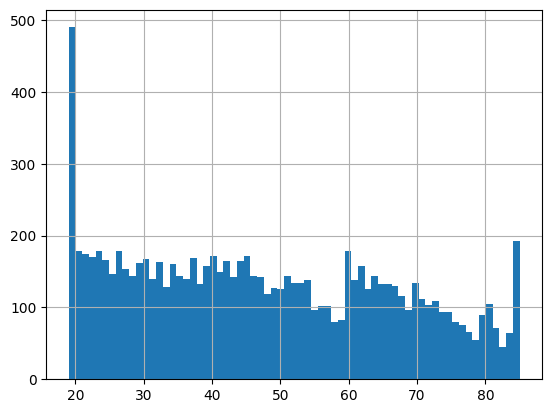

In [8]:
train_df = df[features + meta_features].copy().dropna()
train_df = train_df.dropna()
train_df.dropna()['age'].hist(bins=train_df['age'].nunique())

In [9]:
train_df.shape

(9120, 13)

In [10]:
train_df[features]

,gender,Systolic blood pressure average,Body Mass Index (kg/m**2),Waist to Height ratio,Systolic blood pressure average^2,Body Mass Index (kg/m**2)^2,Waist to Height ratio^2,Systolic blood pressure average_log,Body Mass Index (kg/m**2)_log,Waist to Height ratio_log
29315,1,98.0,24.90,0.563218,9604.0,620.0100,0.317215,4.584967,3.214868,-0.574088
29318,1,122.0,29.10,0.560292,14884.0,846.8100,0.313927,4.804021,3.370738,-0.579298
29319,0,114.0,22.56,0.503704,12996.0,508.9536,0.253717,4.736198,3.116178,-0.685767
29320,0,123.0,29.39,0.556783,15129.0,863.7721,0.310008,4.812184,3.380654,-0.585579
29323,1,142.0,30.94,0.568122,20164.0,957.2836,0.322763,4.955827,3.432050,-0.565419
...,...,...,...,...,...,...,...,...,...,...
48064,1,117.0,25.94,0.545973,13689.0,672.8836,0.298087,4.762174,3.255786,-0.605185
48065,0,147.0,30.30,0.623780,21609.0,918.0900,0.389102,4.990433,3.411148,-0.471957
48066,0,144.0,23.53,0.578980,20736.0,553.6609,0.335218,4.969813,3.158276,-0.546486
48070,1,166.0,28.54,0.620649,27556.0,814.5316,0.385205,5.111988,3.351307,-0.476990


In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from joblib import dump, load
import sys, os

def train_and_save_models(model, df, features, save_to='models/', n_splits=5):
    if not os.path.exists(save_to): os.mkdir(save_to)
    models_saved = []
    X = df[features]
    y = df["age"]

    kf = KFold(n_splits=n_splits)
    fold = 0
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df.loc[df.iloc[test_index].index, 'y_pred'] = y_pred.tolist()

        # Save the model for this fold
        model_filename = f'{save_to}/model_fold_{fold}.joblib'
        dump(model, model_filename)
        models_saved.append(model_filename)
        print(f'Model saved for fold {fold}: {model_filename}')

    return df, models_saved


train_df, models_saved = train_and_save_models(
    # CatBoostRegressor(silent=True, random_state=42, max_depth=5, cat_features=['gender']), 
    LinearRegression(), 
    train_df, features, save_to='models/catboost')
mae = mean_absolute_error(train_df['age'], train_df['y_pred'])
r2 = r2_score(train_df['age'], train_df['y_pred'])

print('MAE', mae, 'R2', r2)
# Plot y_pred against age
plt.figure(figsize=(10, 6))
plt.scatter(train_df['age'], train_df['y_pred'], alpha=0.5)
plt.title('Predicted Age vs. Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.plot([train_df['age'].min(), train_df['age'].max()], [train_df['age'].min(), train_df['age'].max()], 'k--') # Diagonal line
plt.show()

KeyError: "['gender', 'Body Mass Index (kg/m**2)', 'Waist to Height ratio', 'Systolic blood pressure average^2', 'Body Mass Index (kg/m**2)^2', 'Waist to Height ratio^2', 'Systolic blood pressure average_log', 'Body Mass Index (kg/m**2)_log', 'Waist to Height ratio_log'] not in index"

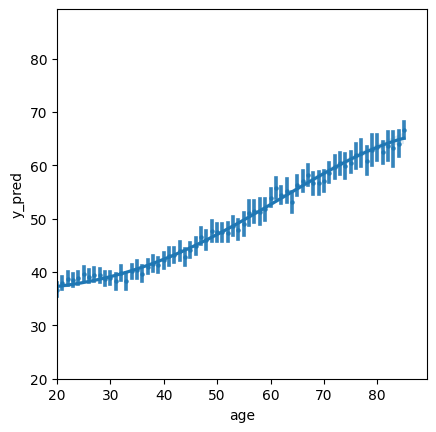

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming train_df is your DataFrame and 'age' is the actual age while 'y_pred' is the predicted age.

# Create the plot
sns.regplot(
    x='age',
    y='y_pred',
    data=train_df,
    marker='o',
    scatter_kws={'s': 5, 'alpha': 0.9},
    order=4, 
    x_estimator=np.mean
)

# Get current axis
ax = plt.gca()

# Find maximum value to set as limit by comparing max of actual and predicted ages
max_limit = max(train_df['age'].max(), train_df['y_pred'].max())

# Set the same scale for both axes
ax.set_xlim(20, max_limit)
ax.set_ylim(20, max_limit)

# Optionally, to enforce a square aspect ratio
ax.set_aspect('equal', 'box')

plt.show()


['Systolic blood pressure average',
 'Hip Circumference (cm)',
 'Weight (kg)',
 'Standing Height (cm)',
 'Waist Circumference (cm)',
 'gender',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio',
 'Waist to Hip ratio']

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming train_df is your DataFrame and 'age' is the actual age while 'y_pred' is the predicted age.

# Create the plot
sns.regplot(
    x='age',
    y='Body Mass Index (kg/m**2)',
    data=train_df,
    marker='o',
    scatter_kws={'s': 5, 'alpha': 0.9},
    order=4, 
    x_estimator=np.mean
)

# Get current axis
ax = plt.gca()

plt.show()


KeyError: 'Body Mass Index (kg/m**2)'

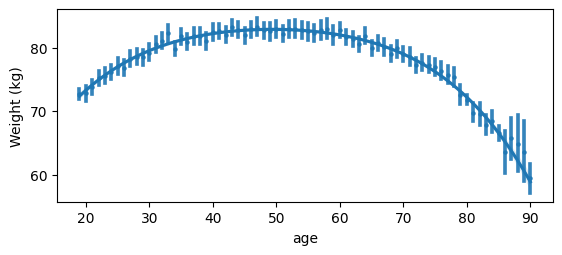

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming train_df is your DataFrame and 'age' is the actual age while 'y_pred' is the predicted age.

# Create the plot
sns.regplot(
    x='age',
    y='Weight (kg)',
    data=train_df,
    marker='o',
    scatter_kws={'s': 5, 'alpha': 0.9},
    order=4, 
    x_estimator=np.mean
)

# Get current axis
ax = plt.gca()

# Optionally, to enforce a square aspect ratio
ax.set_aspect('equal', 'box')

plt.show()


In [55]:
test_sample = pd.DataFrame(    { 
    "Age": 45,
    "Weight_kg": 95,
    "Standing_Height_cm": 181,
    "Waist_Circumference_cm": 96,
    "Hip_Circumference_cm": 106,
    "Systolic_blood_pressure_average": 120,
    "Gender": "Male"
  }, index=[0])
test_sample

,Age,Weight_kg,Standing_Height_cm,Waist_Circumference_cm,Hip_Circumference_cm,Systolic_blood_pressure_average,Gender
0,45,95,181,96,106,120,Male


In [58]:
train_df.iloc[0]

Systolic blood pressure average                                                                  NaN
Hip Circumference (cm)                                                                           NaN
Weight (kg)                                                                                     81.6
Standing Height (cm)                                                                           178.8
Waist Circumference (cm)                                                                        88.8
age                                                                                               21
Respondent sequence number                                                                       3.0
Respondent sequence number that includes an identifier for NHANES III and NHANES continuous      I-3
Name: 0, dtype: object

In [90]:
train_data = pd.read_csv('train_df.csv')

train_data['Body Mass Index (kg/m**2)'] = (train_data['Weight (kg)'] / ((train_data['Standing Height (cm)']*0.01)**2)).round(2)
train_data['Waist to Height ratio'] = train_data['Waist Circumference (cm)'] / train_data['Standing Height (cm)']
train_data['Waist to Hip ratio'] = train_data['Waist Circumference (cm)'] / train_data['Hip Circumference (cm)']

model = load(f'models/catboost/model_fold_1.joblib')
model.feature_names_

['Systolic blood pressure average',
 'Hip Circumference (cm)',
 'Weight (kg)',
 'Standing Height (cm)',
 'Waist Circumference (cm)',
 'gender',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio',
 'Waist to Hip ratio']

In [128]:
train_datatrain_df = train_data[train_data['gender'].notna()]
# train_data.loc[0, 'Weight (kg)'] = 84
train_data.loc[0, 'Weight (kg)'] = 84
train_data.loc[0]


Unnamed: 0                                                                                            0
Systolic blood pressure average                                                                     NaN
Hip Circumference (cm)                                                                              NaN
Weight (kg)                                                                                        84.0
Standing Height (cm)                                                                              178.8
Waist Circumference (cm)                                                                           88.8
gender                                                                                             Male
Body Mass Index (kg/m**2)                                                                         25.52
Waist to Height ratio                                                                          0.496644
Waist to Hip ratio                                              

In [129]:
model.predict(train_data.iloc[0][model.feature_names_])


34.31642171364534

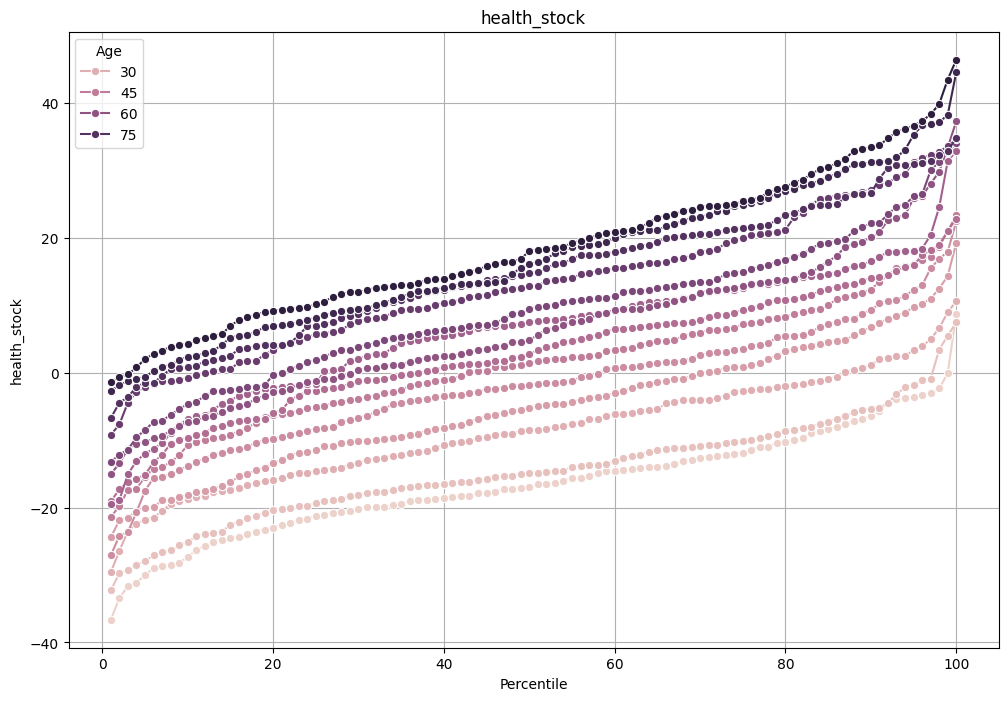

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature = 'health_stock'

train_df['health_stock'] = train_df['age'] - train_df['y_pred']
train_df[['y_pred', 'age', 'health_stock']]


dff = train_df[[feature, 'gender', 'age']].dropna()

# Computing percentiles within each age group for FEV
# Here we prepare a DataFrame where each column represents an age and each row represents a percentile (0-100)

# Getting unique ages
unique_ages = dff['age'].unique()

# Creating an empty DataFrame for percentiles
percentile_df = pd.DataFrame(index=range(1, 101))  # 1-100 percentiles

for age in unique_ages:
    age_specific_fev = dff[dff['age'] == age][feature]
    percentiles = np.percentile(age_specific_fev, range(1, 101))
    percentile_df[age] = percentiles

# Sorting columns by age for easier interpretation
percentile_df = percentile_df[sorted(percentile_df.columns)]


# Selecting a few age groups for visualization to avoid clutter
selected_ages = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

# Creating a new DataFrame for selected ages
selected_percentile_df = percentile_df[selected_ages]

# Melting the DataFrame for easier plotting with seaborn
melted_df = selected_percentile_df.reset_index().melt(id_vars='index', value_vars=selected_ages)
melted_df.rename(columns={'index': 'Percentile', 'variable': 'Age', 'value': 'health_stock'}, inplace=True)

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='Percentile', y='health_stock', hue='Age', marker='o')
plt.title(feature)
plt.xlabel('Percentile')
plt.ylabel(feature)
plt.grid(True)
plt.legend(title='Age')
plt.show()

In [61]:
melted_df

,Percentile,Age,Health stock
0,1,20,-36.626438
1,2,20,-33.397411
2,3,20,-31.666966
3,4,20,-31.113652
4,5,20,-30.028223
...,...,...,...
1395,96,85,37.322334
1396,97,85,38.322904
1397,98,85,39.856185
1398,99,85,43.485436


In [36]:
import pandas as pd
import numpy as np

def create_and_save_health_stock_percentile_dff(train_df):
    train_df['health_stock'] = train_df['age'] - train_df['y_pred']
    train_df[['y_pred', 'age', 'health_stock']]

    dff = train_df[[feature, 'gender', 'age']].dropna()
    selected_ages = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
    percentile_df = pd.DataFrame(index=range(1, 101))  # 1-100 percentiles

    for age in selected_ages:
        # Filter data for the current age, allowing a 5-year margin since exact ages may not be present
        age_group_data = dff[(dff['age'] >= age) & (dff['age'] < age + 5)]['health_stock']
        if not age_group_data.empty:
            percentiles = np.percentile(age_group_data, range(1, 101))
            percentile_df[age] = percentiles
        else:
            # If there's no data for the age group, fill with NaN or a placeholder
            percentile_df[age] = [np.nan] * 100

    # Now percentile_df contains percentile values for health_stock within the selected age groups
    percentile_df


,20,25,30,35,40,45,50,55,60,65,70,75,80,85
1,-33.726620,-32.396416,-27.676294,-24.422975,-27.037153,-21.265907,-20.137636,-18.880734,-16.952421,-13.572312,-9.906891,-6.080170,-3.439078,-1.341734
2,-31.589460,-29.369718,-24.704183,-22.139413,-23.781910,-19.832024,-18.004886,-16.784178,-14.622343,-11.632136,-7.997184,-3.699707,-0.991925,-0.686411
3,-30.604702,-27.902728,-22.845957,-20.654922,-21.059153,-18.183418,-16.140147,-14.790932,-12.891276,-10.120985,-5.987620,-2.877075,0.785711,-0.254404
4,-29.862639,-27.021909,-21.972083,-19.798942,-19.044329,-17.187735,-14.680877,-13.189947,-12.216465,-8.675093,-4.552852,-2.073518,1.226966,0.783019
5,-28.968801,-26.023187,-20.606414,-18.887385,-17.166924,-15.229679,-13.481773,-11.307427,-10.928403,-7.634113,-4.111876,-1.447273,2.348044,2.029357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-2.238415,1.130442,7.434292,11.444996,14.721557,17.236643,20.473539,23.202427,26.224228,28.206737,31.134526,33.464465,37.061403,37.322334
97,-1.727491,2.241301,8.546113,12.625198,15.835011,17.976186,21.409282,23.935430,27.490246,29.229297,32.138477,34.737726,38.018753,38.322904
98,-0.340304,3.702822,9.315252,13.662815,16.772285,19.516558,23.006938,24.958521,29.017599,31.724398,33.300620,37.198974,40.704076,39.856185
99,1.433607,7.011954,10.792387,15.712837,18.211221,20.545284,26.446659,27.920300,32.108948,34.477803,35.833801,39.863222,45.067909,43.485436


In [74]:
        

def find_bioage_percentile(age: int, health_stock: float, percentile_df: pd.DataFrame) -> str:
    """
    Find the percentile rank of an individual's health_stock within their age group.
    
    Parameters:
    - age: The age of the individual.
    - health_stock: The health_stock value of the individual.
    - dff: The DataFrame containing health_stock values across different ages.
    
    Returns:
    - A string indicating how the individual's health_stock compares to others in their age group.
    """
    percentile_df = percentile_df.reset_index().melt(id_vars='index')
    percentile_df.rename(columns={'index': 'Percentile', 'variable': 'Age', 'value': 'health_stock'}, inplace=True)

    # Determine the age group
    age_group = age // 5 * 5  # Group by every 5 years, aligning with the provided logic
    if age_group < 20:
        age_group = 20
    elif age_group > 85:
        age_group = 85
    
    # Filter the DataFrame for the specific age group
    age_group_dff = percentile_df[percentile_df['Age'].astype(str) == str(age_group)]

    # Compute the percentile of the individual's health_stock within the age group
    percentile_rank = round(np.mean(health_stock > age_group_dff['health_stock']) * 100, 2)
    
    return {"leaderbord_text": f"Ваше значение биовозраста лучше чем у {percentile_rank}% людей вашей возрастной группы",
            "leaderbord_value": percentile_rank,
            "age_group_dff": age_group_dff
            }

health_stock = 15
leaderbord = find_bioage_percentile(age, health_stock, health_stock_percentile_dff)
leaderbord

{'leaderbord_text': 'Ваше значение биовозраста лучше чем у 38.0% людей вашей возрастной группы',
 'leaderbord_value': 38.0,
 'age_group_dff':       Percentile Age  health_stock
 1200           1  80     -3.439078
 1201           2  80     -0.991925
 1202           3  80      0.785711
 1203           4  80      1.226966
 1204           5  80      2.348044
 ...          ...  ..           ...
 1295          96  80     37.061403
 1296          97  80     38.018753
 1297          98  80     40.704076
 1298          99  80     45.067909
 1299         100  80     47.746427
 
 [100 rows x 3 columns]}

In [69]:
health_stock_percentile_dff = pd.read_csv('models/health_stock_percentile_dff.csv', index_col=0)

percentile_df = health_stock_percentile_dff.reset_index().melt(id_vars='index')
percentile_df.rename(columns={'index': 'Percentile', 'variable': 'Age', 'value': 'health_stock'}, inplace=True)
percentile_df

,Percentile,Age,health_stock
0,1,20,-33.726620
1,2,20,-31.589460
2,3,20,-30.604702
3,4,20,-29.862639
4,5,20,-28.968801
...,...,...,...
1395,96,85,37.322334
1396,97,85,38.322904
1397,98,85,39.856185
1398,99,85,43.485436


In [72]:
percentile_df[percentile_df['Age']== str(age_group)]


,Percentile,Age,health_stock
0,1,20,-33.726620
1,2,20,-31.589460
2,3,20,-30.604702
3,4,20,-29.862639
4,5,20,-28.968801
...,...,...,...
95,96,20,-2.238415
96,97,20,-1.727491
97,98,20,-0.340304
98,99,20,1.433607


In [70]:
age_group

20

In [47]:
percentile_df

,20,25,30,35,40,45,50,55,60,65,70,75,80,85
1,-33.726620,-32.396416,-27.676294,-24.422975,-27.037153,-21.265907,-20.137636,-18.880734,-16.952421,-13.572312,-9.906891,-6.080170,-3.439078,-1.341734
2,-31.589460,-29.369718,-24.704183,-22.139413,-23.781910,-19.832024,-18.004886,-16.784178,-14.622343,-11.632136,-7.997184,-3.699707,-0.991925,-0.686411
3,-30.604702,-27.902728,-22.845957,-20.654922,-21.059153,-18.183418,-16.140147,-14.790932,-12.891276,-10.120985,-5.987620,-2.877075,0.785711,-0.254404
4,-29.862639,-27.021909,-21.972083,-19.798942,-19.044329,-17.187735,-14.680877,-13.189947,-12.216465,-8.675093,-4.552852,-2.073518,1.226966,0.783019
5,-28.968801,-26.023187,-20.606414,-18.887385,-17.166924,-15.229679,-13.481773,-11.307427,-10.928403,-7.634113,-4.111876,-1.447273,2.348044,2.029357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-2.238415,1.130442,7.434292,11.444996,14.721557,17.236643,20.473539,23.202427,26.224228,28.206737,31.134526,33.464465,37.061403,37.322334
97,-1.727491,2.241301,8.546113,12.625198,15.835011,17.976186,21.409282,23.935430,27.490246,29.229297,32.138477,34.737726,38.018753,38.322904
98,-0.340304,3.702822,9.315252,13.662815,16.772285,19.516558,23.006938,24.958521,29.017599,31.724398,33.300620,37.198974,40.704076,39.856185
99,1.433607,7.011954,10.792387,15.712837,18.211221,20.545284,26.446659,27.920300,32.108948,34.477803,35.833801,39.863222,45.067909,43.485436


In [52]:
def find_bioage_percentile(age: int, health_stock: float, dff: pd.DataFrame) -> str:
    """
    Find the percentile rank of an individual's health_stock within their age group.
    
    Parameters:
    - age: The age of the individual.
    - health_stock: The health_stock value of the individual.
    - dff: The DataFrame containing health_stock values across different ages.
    
    Returns:
    - A string indicating how the individual's health_stock compares to others in their age group.
    """
    # Determine the age group
    age_group = age // 5 * 5  # Group by every 5 years, aligning with the provided logic
    if age_group < 20:
        age_group = 20
    elif age_group > 85:
        age_group = 85
    
    # Filter the DataFrame for the specific age group
    age_group_dff = dff[dff['age'] == age_group]
    
    if age_group_dff.empty:
        return "Информация по вашей возрастной группе отсутствует."
    
    # Compute the percentile of the individual's health_stock within the age group
    percentile_rank = round(np.mean(health_stock > age_group_dff[feature]) * 100, 2)
    
    return {"leaderbord_text": f"Ваше значение биовозраста лучше чем у {percentile_rank}% людей вашей возрастной группы",
            "leaderbord_value": percentile_rank}

# Example usage
age = 21
health_stock_value = 5  # Example health_stock value

# Assuming 'dff' is your DataFrame containing health_stock values
result = find_bioage_percentile(age, health_stock_value, dff)
print(result)

{'leaderbord_text': 'Ваше значение биовозраста лучше чем у 99.44% людей вашей возрастной группы', 'leaderbord_value': 99.44}


In [53]:
dff

,health_stock,gender,age
29315,34.182906,1,77
29318,6.372033,1,49
29319,-22.901129,0,19
29320,19.138082,0,59
29323,-7.483226,1,43
...,...,...,...
48064,-12.764925,1,32
48065,5.494714,0,67
48066,11.338897,0,81
48070,11.419416,1,85


In [116]:
cb_model = model

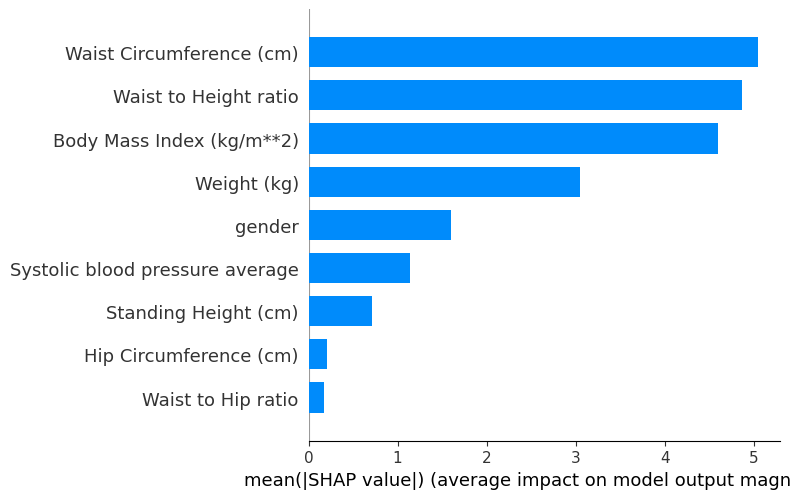

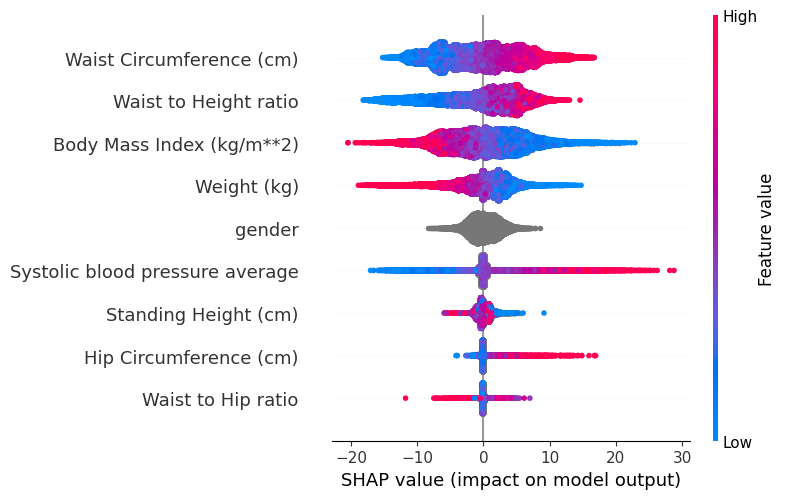

In [119]:
import shap  

X = train_data[cb_model.feature_names_]
explainer = shap.Explainer(cb_model)
shap_values = explainer(X)

# Summary plot for all data
shap.summary_plot(shap_values, X, plot_type="bar")

# This will display a bar chart showing the average impact of each feature on model output magnitude.
# The features are ranked by their importance.
# Additionally, to see how each feature value affects the predictions, you can use:
shap.summary_plot(shap_values, X)
# This plot shows the SHAP values on a color scale, indicating how high or low feature values
# influence the prediction outcome across all the data points.



In [298]:
import shap  # Ensure SHAP is installed
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
1 - скорость омоложения по биовозрасту
2 - лидерборд абсолютных значений
3 - 


In [353]:
x = train_df.iloc[[0]].reset_index()
print('predicted age:', round(cb_model.predict(x[features].values)[0], 2))
x

predicted age: 67.95


,index,gender,Systolic blood pressure average,Estimated Glomerular Filtration Rate (mL/min/1.73 m2),alpha-tocopherol (µg/dL),Serum homocysteine: SI (umol/L),Serum ferritin (ng/mL),Serum creatinine (mg/dL),Serum blood urea nitrogen (mg/dL),Serum HDL cholesterol (mg/dL),Serum albumin: SI (g/L),Serum C-reactive protein (mg/dL),Body Mass Index (kg/m**2),Waist to Height ratio,age,Respondent sequence number,Respondent sequence number that includes an identifier for NHANES III and NHANES continuous,y_pred
0,29315,Male,98.0,91.026873,1488.4,9.78,55.0,0.7,19.0,54.0,45.0,0.36,24.9,0.563218,77,2.0,C-2,63.313293


In [351]:
x.loc[0, 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)']=100
print('predicted age:', round(cb_model.predict(x[features].values)[0], 2))

predicted age: 59.4


In [387]:
x.loc[0, 'alpha-tocopherol (µg/dL)']=1200
print('predicted age:', round(cb_model.predict(x[features].values)[0], 2))

predicted age: 65.06


# Get percentiles

In [360]:
df[['Forced expiratory vol(FEV),.5 sec,max-ml', 'gender', 'age']].dropna()

,"Forced expiratory vol(FEV),.5 sec,max-ml",gender,age
0,3576.0,Male,21
1,2545.0,Female,32
2,1988.5,Female,48
3,3260.0,Male,35
4,2502.0,Male,48
...,...,...,...
29304,1501.0,Female,10
29306,3343.0,Male,15
29307,2020.0,Female,12
29309,2126.0,Male,10


In [375]:
df['age'].value_counts().sort_index()[:40]

age
1     4076
2     4152
3     3080
4     3173
5     2912
6     2491
7     2496
8     2524
9     2499
10    2449
11    2520
12    2591
13    2561
14    2603
15    2390
16    2618
17    2491
18    2386
19    2305
20    1284
21    1269
22    1319
23    1327
24    1308
25    1225
26    1239
27    1192
28    1226
29    1260
30    1285
31    1285
32    1247
33    1213
34    1232
35    1164
36    1263
37    1161
38    1192
39    1153
40    1307
Name: count, dtype: int64

In [27]:
import fastapi
import uvicorn
import pandas
import pydantic
import joblib
import numpy
import streamlit
import sklearn
import catboost
print(fastapi.__version__)
print(uvicorn.__version__)
print(pandas.__version__)
print(pydantic.__version__)
print(joblib.__version__)
print(numpy.__version__)
print(streamlit.__version__)
print(sklearn.__version__)
print(catboost.__version__)

0.110.0
0.27.1
2.2.1
2.5.3
1.3.2
1.26.4
1.32.1
1.4.1.post1
1.2.3
